<a href="https://colab.research.google.com/github/Teodosiodg2002/Diabetes-Classification/blob/main/DiabetesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 1: Pre-procesamiento y Clasificación Binaria

---

## 1. Introducción y Carga de Datos

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('diabetes.csv', sep=';')

df.replace(-999, np.nan, inplace=True)

print("✅ Datos cargados correctamente.")
print(f"Dimensiones: {df.shape[0]} filas y {df.shape[1]} columnas.")

df.head()

✅ Datos cargados correctamente.
Dimensiones: 60796 filas y 22 columnas.


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1.0,26.0,0,0,0.0,1,0,...,1,0.0,3,5,30,0,1,4,6,8.0
1,0,1,1,1.0,26.0,1,1,0.0,0,1,...,1,0.0,3,0,0,0,1,12,6,8.0
2,0,0,0,1.0,26.0,0,0,0.0,1,1,...,1,NaN,1,0,10,0,1,13,6,8.0
3,0,1,1,1.0,28.0,1,0,0.0,1,1,...,1,0.0,3,0,3,0,1,11,6,8.0
4,0,0,0,1.0,29.0,1,0,0.0,1,1,...,1,0.0,2,0,0,0,0,8,5,8.0


## 2. Análisis Exploratorio de Datos (EDA)

/tmp/ipython-input-3875242437.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Diabetes_binary', data=df, palette='viridis')


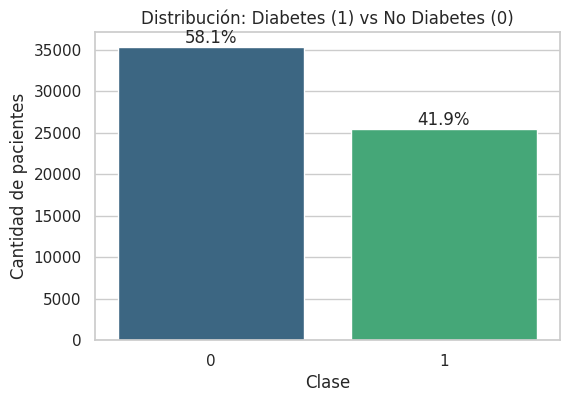

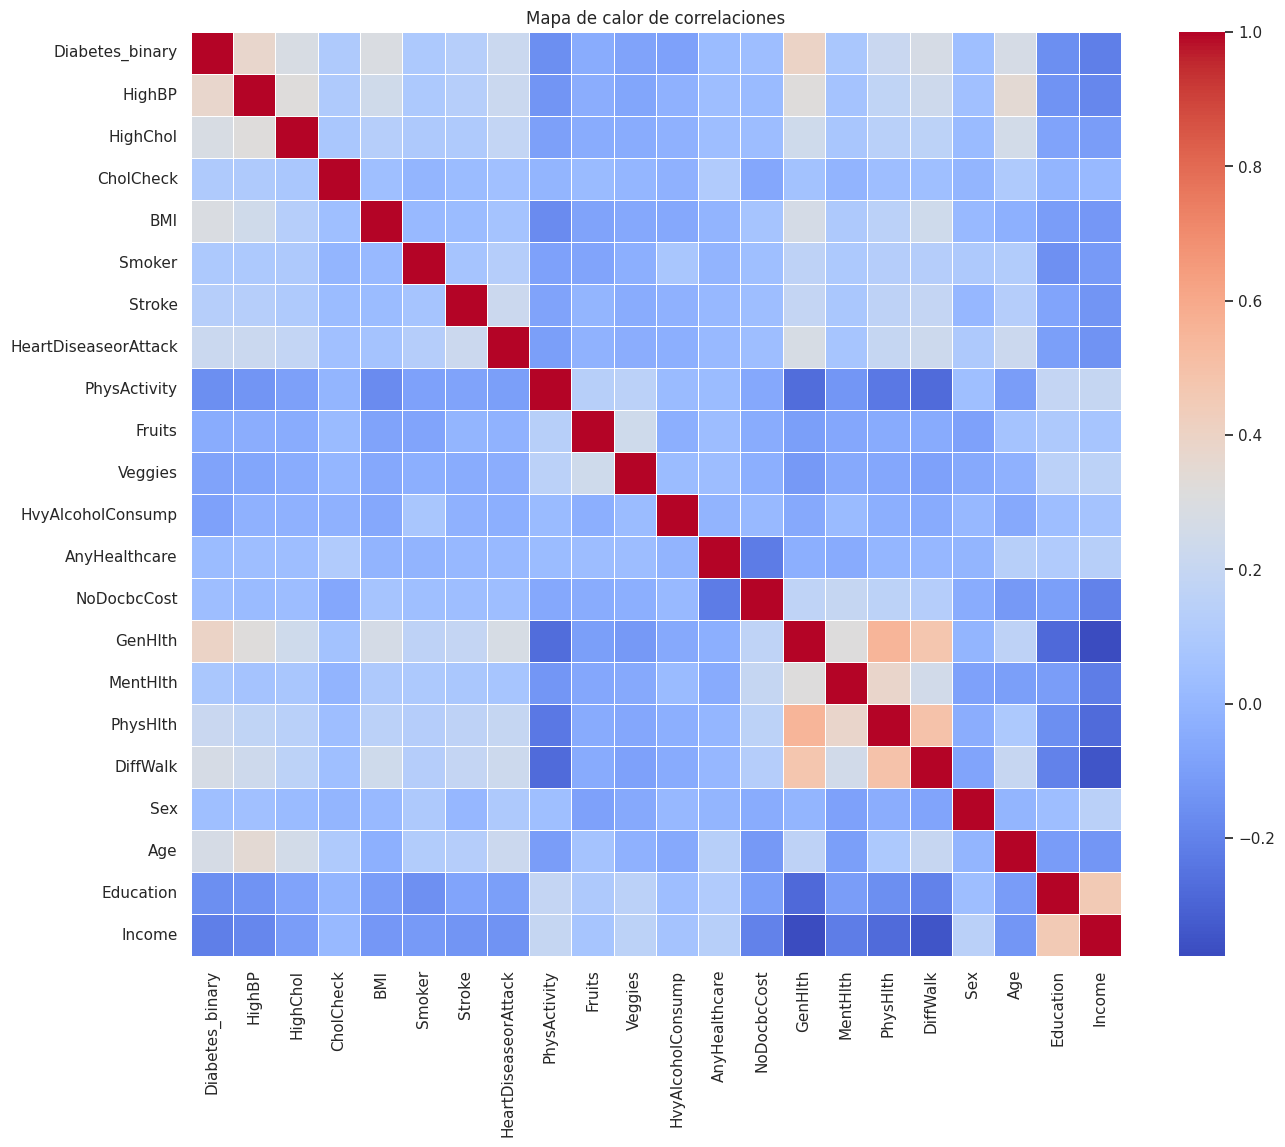

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual simple
sns.set(style="whitegrid")

# --- A. Ver el balance de la variable objetivo (Diabetes_binary) ---
plt.figure(figsize=(6, 4))
# Usamos la columna 'Diabetes_binary' que vimos en tu error
ax = sns.countplot(x='Diabetes_binary', data=df, palette='viridis')

plt.title('Distribución: Diabetes (1) vs No Diabetes (0)')
plt.xlabel('Clase')
plt.ylabel('Cantidad de pacientes')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

# --- B. Matriz de Correlación ---
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de correlaciones')
plt.show()

## 3. Pre-procesamiento

Tratamiento de valores perdidos (-999).

Codificación y Normalización.

Tratamiento de clases desbalanceadas.




In [8]:
from sklearn.preprocessing import MinMaxScaler

# 3.1 Tratamiento de Valores Perdidos (Imputación)
nulos_antes = df.isnull().sum().sum()
print(f"Total de valores nulos encontrados: {nulos_antes}")

df.fillna(df.median(), inplace=True)

print(f"Total de valores nulos tras imputación: {df.isnull().sum().sum()}")


# 3.2 Identificación de Columnas Numéricas vs Binarias
cols_a_escalar = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

# Verificamos que existan en el dataset antes de intentar escalar
cols_existentes = [col for col in cols_a_escalar if col in df.columns]

print(f"\nVariables seleccionadas para normalización (Min-Max): {cols_existentes}")


# 3.3 Normalización (Escalado Min-Max)
scaler = MinMaxScaler()

df_scaled = df.copy()

if cols_existentes:
    df_scaled[cols_existentes] = scaler.fit_transform(df[cols_existentes])
    print("✅ Normalización completada.")
else:
    print("⚠️ No se encontraron las columnas numéricas esperadas.")

display(df_scaled.head())

Total de valores nulos encontrados: 0
Total de valores nulos tras imputación: 0

Variables seleccionadas para normalización (Min-Max): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
✅ Normalización completada.


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1.0,0.162791,0,0,0.0,1,0,...,1,0.0,0.50,0.166667,1.000000,0,1,0.250000,1.0,1.0
1,0,1,1,1.0,0.162791,1,1,0.0,0,1,...,1,0.0,0.50,0.000000,0.000000,0,1,0.916667,1.0,1.0
2,0,0,0,1.0,0.162791,0,0,0.0,1,1,...,1,0.0,0.00,0.000000,0.333333,0,1,1.000000,1.0,1.0
3,0,1,1,1.0,0.186047,1,0,0.0,1,1,...,1,0.0,0.50,0.000000,0.100000,0,1,0.833333,1.0,1.0
4,0,0,0,1.0,0.197674,1,0,0.0,1,1,...,1,0.0,0.25,0.000000,0.000000,0,0,0.583333,0.8,1.0


## 4. Division de Datos (Train / Test / Validation)

In [9]:
# --- BLOQUE 4: DIVISIÓN DE DATOS EN 3 CONJUNTOS (TRAIN / VAL / TEST) ---
from sklearn.model_selection import train_test_split

# 4.1 Preparación
target = 'Diabetes_binary'
X = df_scaled.drop(target, axis=1)
y = df_scaled[target]

# 4.2 Primera división: Separamos Train (70%) del resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4.3 Segunda división: Partimos el "resto" en Validación (15%) y Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 4.4 Verificación de dimensiones
print("--- Dimensiones de los Conjuntos Generados ---")
print(f"1. Train (Entrenamiento): {X_train.shape[0]} filas ({(len(X_train)/len(df))*100:.1f}%)")
print(f"2. Val   (Validación):    {X_val.shape[0]} filas ({(len(X_val)/len(df))*100:.1f}%)")
print(f"3. Test  (Prueba Final):  {X_test.shape[0]} filas ({(len(X_test)/len(df))*100:.1f}%)")

# 4.5 Verificación de balance de clases (debe ser casi igual en los 3)
print("\n--- Proporción de Diabetes (Clase 1) en cada conjunto ---")
print(f"Original: {y.mean():.4f}")
print(f"Train:    {y_train.mean():.4f}")
print(f"Val:      {y_val.mean():.4f}")
print(f"Test:     {y_test.mean():.4f}")

--- Dimensiones de los Conjuntos Generados ---
1. Train (Entrenamiento): 42557 filas (70.0%)
2. Val   (Validación):    9119 filas (15.0%)
3. Test  (Prueba Final):  9120 filas (15.0%)

--- Proporción de Diabetes (Clase 1) en cada conjunto ---
Original: 0.4186
Train:    0.4186
Val:      0.4186
Test:     0.4186
